# Connect to Google Drive

In [0]:
#Step 1 part 1: connect to drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130942 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.4-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.4-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.4-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

# Prepare Data

In [0]:
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
from os import walk
from random import sample
from matplotlib.pyplot import imread
from skimage.transform import resize
import pickle, cv2
from sklearn.preprocessing import LabelEncoder

In [0]:
def make_img_df():
    
    img_root = 'drive/ML-Pandora/img/'
    img_details = pd.read_csv('drive/ML-Pandora/Data/all_data_info.csv')
    
    keepers = ['Impressionism','Expressionism','Surrealism']

    df_details = img_details[img_details['style'].isin(keepers)]
    img_names = df_details['new_filename'].values
    
    files = [f for f in os.listdir(img_root) if os.path.isfile(os.path.join(img_root, f))]

    styles = [df_details.loc[df_details['new_filename'] == name, 'style'].iloc[0] for name in files]

    images = ['{}{}'.format(img_root, name) for name in files]

    final_df = pd.DataFrame({'img_path':images, 'class':styles})
    final_df.to_pickle('drive/ML-Pandora/Data/paths_classes_03.pkl')
    
    print("Saved in a .pkl file")

In [0]:
def prepare_data():
    df = pd.read_pickle('drive/ML-Pandora/Data/paths_classes_03.pkl')

    paths_and_classes_small, class_names = sampled_paths_classes(df)

    with open('drive/ML-Pandora/Data/paths_and_classes_small.pkl', 'wb') as f:
        pickle.dump(paths_and_classes_small, f)

    class_dict = {index: art_class for index, art_class in zip(range(3), class_names)}

    with open('drive/ML-Pandora/Data/class_dict.pkl', 'wb') as f:
        pickle.dump(class_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

    images = [cv2.imread(path,1) for path, label in paths_and_classes_small]
    
    for path, label in paths_and_classes_small:
        img = cv2.imread(path,1)
        try:
            print(img.shape[0])
        except AttributeError:
            print(path)
            continue

    x = np.array([prepare_image(image) for image in images])
    y = np.array([style for path, style in paths_and_classes_small])
    
    np.savez('drive/ML-Pandora/Data/images_labels_224.npz', x=x, y=y)
    print("Saved in a .npz file")

In [0]:
def sampled_paths_classes(df):
    # encode art categories as numerical values
    encoder = LabelEncoder()
    y = encoder.fit_transform(df['class'].astype('str'))
    n_classes = len(np.unique(y))
    paths_and_classes = list(zip(df['img_path'].tolist(), y))

    paths_and_classes_small = []
    for x in range(n_classes):
        temp = [(path, style) for path, style in paths_and_classes if style == x]
        samp = sample(temp, 398)
        for path, style in samp:
            paths_and_classes_small.append((path,style))

    np.random.shuffle(paths_and_classes_small)

    return paths_and_classes_small, encoder.classes_

In [0]:
def prepare_image(image, target_width=224, target_height=224, max_zoom=0.2):
    height = image.shape[0]
    width = image.shape[1]

    image_ratio = width / height
    target_image_ratio = target_width / target_height
    
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height

    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)

    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height

    image = image[y0:y1, x0:x1]

    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    image = cv2.resize(image, (target_width, target_height))

    return image.astype(np.float32) / 255

In [0]:
make_img_df()

Saved in a .pkl file


In [0]:
prepare_data()

1134
382
375
1200
464
479
508
372
358
1014
396
500
367
500
800
636
421
500
413
600
443
452
426
477
304
1037
670
525
500
1256
410
611
500
500
453
315
400
737
456
600
1024
651
500
600
738
1446
711
1467
414
500
484
420
204
500
500
585
500
462
405
1200
500
649
402
666
253
436
250
790
304
572
382
500
500
480
500
436
500
600
410
600
614
500
1000
472
369
370
400
362
500
590
500
573
421
465
378
419
500
636
500
488
456
384
500
500
600
315
994
804
351
409
600
500
396
448
500
500
532
373
390
500
1590
500
479
500
960
960
287
500
405
1024
1036
644
428
768
475
500
648
487
1200
376
372
408
1300
352
477
501
675
494
368
627
554
654
416
457
614
497
700
490
500
999
720
626
478
621
419
500
407
821
436
401
344
896
344
614
581
500
599
633
500
320
600
622
450
199
407
343
500
620
1581
500
488
694
500
500
500
420
496
500
714
500
600
500
642
500
619
561
337
607
500
504
500
850
475
412
509
500
317
398
389
500
465
328
381
500
720
468
340
960
611
500
348
622
500
720
452
500
737
361
500
500
406
263
500
496
415
375


# Train Model

In [0]:
import numpy as np
import pandas as pd
from random import sample
import pickle, cv2

from matplotlib.pyplot import imread
import matplotlib.pyplot as plt

import sklearn
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics

from keras import applications, optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras.utils import np_utils
from keras.models import model_from_json
from keras.models import load_model
from keras.utils import plot_model

import json

In [0]:
def train_validation_split(x, y):
    X_training, X_test, y_training, y_test = train_test_split(x, y, stratify=y, random_state=1337)
    X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, stratify=y_training, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [0]:
def one_hot(y_train, y_val, y_test, n_classes):
    y_train = np_utils.to_categorical(y_train, n_classes)
    y_val = np_utils.to_categorical(y_val, n_classes)
    y_test = np_utils.to_categorical(y_test, n_classes)

    return y_train, y_val, y_test

In [0]:
def build_fit_save_cnn(input_shape, n_classes, epochs, batch_size, X_train, X_val, y_train, y_val):
    base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    add_model.add(Dense(512, activation='relu'))
    add_model.add(Dense(512, activation='relu'))
    add_model.add(Dropout(0.25))
    add_model.add(Dense(n_classes, activation='softmax'))

    # combine base model and fully connected layers
    final_model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

    # specify SDG optimizer parameters
    sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

    # compile model
    final_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    history = final_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val))

    score = final_model.evaluate(X_val, y_val, verbose=0)
    print('Val. score:', score[0])
    print('Val. accuracy:', score[1])
    
    plot_model(final_model, to_file='drive/ML-Pandora/CNN-ResNet50-Pandora-Model.svg')
    show_history(history)
    save_model(final_model,history)

    return final_model

In [0]:
def test_predict_score(model, X_test, y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    test_pred = model.predict(X_test)

    print('Test score:', score[0])
    print('Test accuracy:', score[1])

    return test_pred, score

In [0]:
def save_model(model,history):
    
    open('drive/ML-Pandora/Saved_models/CNN-ResNet50-Pandora.json', 'w').close()
    open('drive/ML-Pandora/Saved_models/CNN-ResNet50-Pandora-weights.h5', 'w').close()
    
    model_json = model.to_json()
    with open('drive/ML-Pandora/Saved_models/CNN-ResNet50-Pandora.json', 'w') as json_file:
        json_file.write(model_json)

    model.save_weights('drive/ML-Pandora/Saved_models/CNN-ResNet50-Pandora-weights.h5')
    print('Model saved to disk!')
    
    with open('drive/ML-Pandora/Data/CNN-ResNet50-Pandora-History.json', 'w') as f:
        json.dump(history.history, f)
    print('History saved to disk!')

In [0]:
def show_history(history):
    print(history.history.keys())

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
#     classes = classes[unique_labels(y_true, y_pred)]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes, title=title, 
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()
    return ax

W0622 11:28:18.743406 140174497392512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0622 11:28:18.782509 140174497392512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0622 11:28:18.794361 140174497392512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0622 11:28:18.830910 140174497392512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0622 11:28:18.831789

94658560/94653016 [==============================] - 3s 0us/step


W0622 11:28:33.597212 140174497392512 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0622 11:28:33.668753 140174497392512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0622 11:28:33.810640 140174497392512 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 671 samples, validate on 224 samples
Epoch 1/5
671/671 [==============================] - 24s 36ms/step - loss: 1.2165 - acc: 0.5425 - val_loss: 0.9998 - val_acc: 0.6384
Epoch 2/5
671/671 [==============================] - 10s 14ms/step - loss: 0.1471 - acc: 0.9434 - val_loss: 0.9715 - val_acc: 0.7009
Epoch 3/5
671/671 [==============================] - 10s 14ms/step - loss: 0.0352 - acc: 0.9911 - val_loss: 0.7783 - val_acc: 0.7545
Epoch 4/5
671/671 [==============================] - 10s 15ms/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.7649 - val_acc: 0.7545
Epoch 5/5
671/671 [==============================] - 10s 15ms/step - loss: 0.0038 - acc: 0.9985 - val_loss: 0.7680 - val_acc: 0.7679
Val. score: 0.767974568264825
Val. accuracy: 0.7678571428571429
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


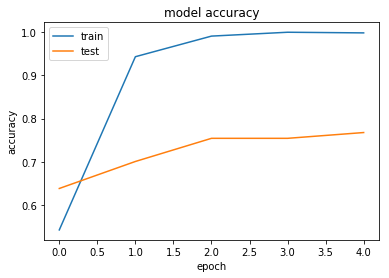

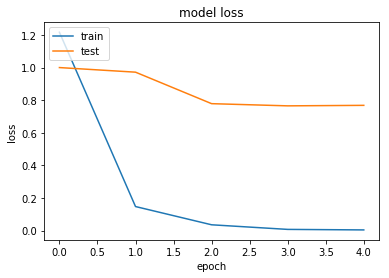

Model saved to disk!
History saved to disk!
Test score: 0.9409187075286406
Test accuracy: 0.7257525091585906


In [0]:
seed = 1337
np.random.seed(seed)

epochs = 5
batch_size = 25
input_shape = (224,224,3)

data = np.load('drive/ML-Pandora/Data/images_labels_224.npz')
x = data['x']
y = data['y']
n_classes = len(np.unique(y))

X_train, X_val, X_test, y_train, y_val, y_test = train_validation_split(x, y)
y_train, y_val, y_test = one_hot(y_train, y_val, y_test, n_classes)
final_model = build_fit_save_cnn(input_shape, n_classes, epochs, batch_size, X_train, X_val, y_train, y_val)
test_pred, score = test_predict_score(final_model, X_test, y_test)

multiclass
multiclass
[1 1 2 1 1 0 1 2 0 1 2 1 1 2 0 0 0 0 2 0 0 1 2 2 1 2 0 2 2 0 1 1 0 1 2 2 1
 0 1 1 1 1 2 0 0 1 1 2 0 0 0 0 1 0 1 2 1 1 1 0 1 2 0 1 1 2 2 2 1 2 1 2 1 2
 1 2 2 0 0 0 0 2 2 2 0 1 0 0 0 1 1 0 0 1 1 0 1 1 0 0 2 2 2 1 1 2 1 1 0 2 2
 1 2 1 1 0 2 2 0 2 0 1 1 1 2 1 1 0 2 0 2 0 2 1 2 2 1 0 0 1 2 0 1 0 0 1 2 2
 1 1 1 2 0 1 1 1 1 0 1 1 2 2 2 0 2 1 0 0 0 1 0 0 1 2 1 0 1 1 1 0 1 0 1 0 1
 2 2 0 0 1 2 2 1 2 2 2 0 1 1 1 0 1 1 1 1 2 1 2 2 2 0 0 0 0 1 2 2 2 0 1 1 2
 1 2 0 0 0 2 2 0 2 2 0 2 2 0 2 0 1 2 2 2 0 2 0 1 2 2 2 1 0 2 1 1 0 0 0 2 1
 0 0 2 2 1 1 1 1 2 0 2 2 0 0 0 0 2 1 2 1 2 1 1 1 1 1 2 2 0 1 0 0 0 2 0 2 0
 1 0 2] [1 1 2 2 1 2 0 2 0 0 2 1 1 2 0 1 1 0 2 0 0 1 0 2 1 0 0 2 2 2 2 1 0 1 2 0 0
 1 1 1 1 0 2 0 0 2 1 2 1 0 1 0 0 0 1 2 1 1 0 0 0 2 0 2 1 2 0 2 1 0 1 2 1 2
 1 2 2 0 0 0 1 2 2 2 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 2 2 0 2 1 1 0 1 1 0 2 2
 1 0 0 1 0 0 0 1 2 0 1 1 2 2 1 1 0 0 0 2 0 2 1 0 2 0 0 0 1 2 2 1 0 0 0 2 2
 1 1 0 2 0 1 0 1 1 0 1 1 2 2 2 0 0 0 0 2 2 1 0 2 1 2 1 1 1 1 0 0 1 0 1

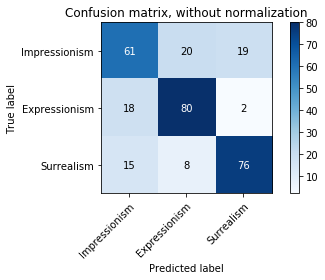

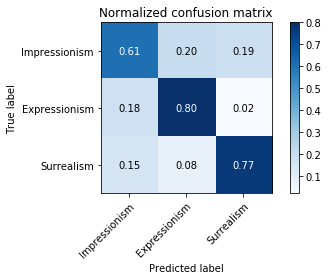

In [0]:
class_names = ["Impressionism", "Expressionism", "Surrealism"]

y_pred = np.argmax(test_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

print(type_of_target(y_pred))
print(type_of_target(y_test_))

print(y_pred,y_test_)
print(len(y_pred),len(y_test_))
    

plot_confusion_matrix(y_test_, y_pred, classes=class_names, title='Confusion matrix, without normalization')
plot_confusion_matrix(y_test_, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.show()

In [0]:
precision_recall_fscore_support(y_test_, y_pred, average='macro')

(0.7243940218642272, 0.7258922558922559, 0.7245356508979484, None)

# Predict

In [0]:
import numpy as np
from sys import argv
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from skimage.transform import resize
import pickle, cv2
from keras import optimizers
from keras.models import load_model
from keras.models import model_from_json

In [0]:
def load_model():
    json_file = open('drive/ML-Pandora/Saved_models/CNN-ResNet50-Pandora.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('drive/ML-Pandora/Saved_models/CNN-ResNet50-Pandora-weights.h5')

    sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    loaded_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return loaded_model

In [0]:
def make_prediction(img_path):
    model = load_model()

    with open('drive/ML-Pandora/Data/class_dict.pkl', 'rb') as f:
        class_dict = pickle.load(f)

    image = cv2.imread(img_path, 1)
    image = prepare_image(image)
    images = []
    images.append(image)
    images = np.array(images)
    image_size = 224
    n_channels = 3
    X_batch = images.reshape(1, image_size, image_size, n_channels)

    preds = model.predict(X_batch)

    top_3 = np.argpartition(preds[0], -3)[-3:]
    top_3 = reversed(top_3[np.argsort(preds[0][top_3])])
    print('Top 3 Predictions:')
    print('------------------')
    for i in top_3:
        print('{0}: {1:.2f}%'.format(class_dict[i], 100 * preds[0][i]))


In [0]:
def prepare_image(image, target_width=224, target_height=224, max_zoom=0.2):
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height

    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)

    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height

    image = image[y0:y1, x0:x1]
    image = cv2.resize(image, (target_width, target_height))

    return image.astype(np.float32) / 255

In [0]:
if __name__ == '__main__':
    img_path = "drive/ML-Pandora/img/zaandam.jpg"
    make_prediction(img_path)

Top 3 Predictions:
------------------
Impressionism: 99.85%
Expressionism: 0.15%
Surrealism: 0.00%
